# Cramer-Rao Lower Bound

Lower bound for the detection on noisy, pixelated images

* dependent on noise, amplitude, z

Take the data model from [J. Chao, et al., *Fisher information theory for parameter estimation in single molecule microscopy: tutorial*, J. Opt. Soc. Am. A 33, B36 (2016).](https://opg.optica.org/abstract.cfm?URI=josaa-33-7-B36).

Eq. 29 states, the Fisher information matrix for a noisy, pixellated image as

$$
\mathbf{I}(\theta) = \sum_{k=1}^K \left(\frac{\partial\nu_{\theta,k}}{\partial\theta}\right)^T \left(\frac{\partial\nu_{\theta,k}}{\partial\theta}\right) \cdot \mathrm{E}\left[\left(\frac{\partial\ln\mathcal{p}_{\theta,k}(z)}{\partial\nu_{\theta,k}}\right)^2\right],
$$

for the parameter vector $\theta$, pixels $k=0,...,K$, mean photoelectron count $\nu_{\theta,k}$ and probability distribution $\mathcal{p}_{\theta,k}(z_k)$ that models the photoelectron count $z_k$ for pixel $k$.

In our simplified model, the photoelectron count is Gaussian distributed with mean $\nu_{\theta,k}$ and standard deviation $\sigma_{\theta,k}\equiv\sigma$.
Thus,

$$
\mathrm{E}\left[\left(\frac{\partial\ln\mathcal{p}_{\theta,k}(z)}{\partial\nu_{\theta,k}}\right)^2\right] = \mathrm{E}\left[\left(\frac{z_k-\nu_{\theta,k}}{\sigma^2}\right)^2\right] = \frac{1}{\sigma^4} \mathrm{E}[(z_k-\nu_{\theta,k})^2] = \frac{1}{\sigma^2},
$$

and the Fisher information matrix becomes

$$
\mathbf{I}(\theta) = \frac{1}{\sigma^2} \sum_{k=1}^K \left(\frac{\partial\nu_{\theta,k}}{\partial\theta}\right)^T \left(\frac{\partial\nu_{\theta,k}}{\partial\theta}\right).
$$

The Cramer-Rao lower bound (CRLB) for the variance of the estimator $\hat{\theta}$ is then given by the inverse of this matrix:

$$
\text{Var}(\hat{\theta}) \geq \mathcal{I}(\theta)^{-1}
$$

Next, we calculate the CRLB for our PSF:

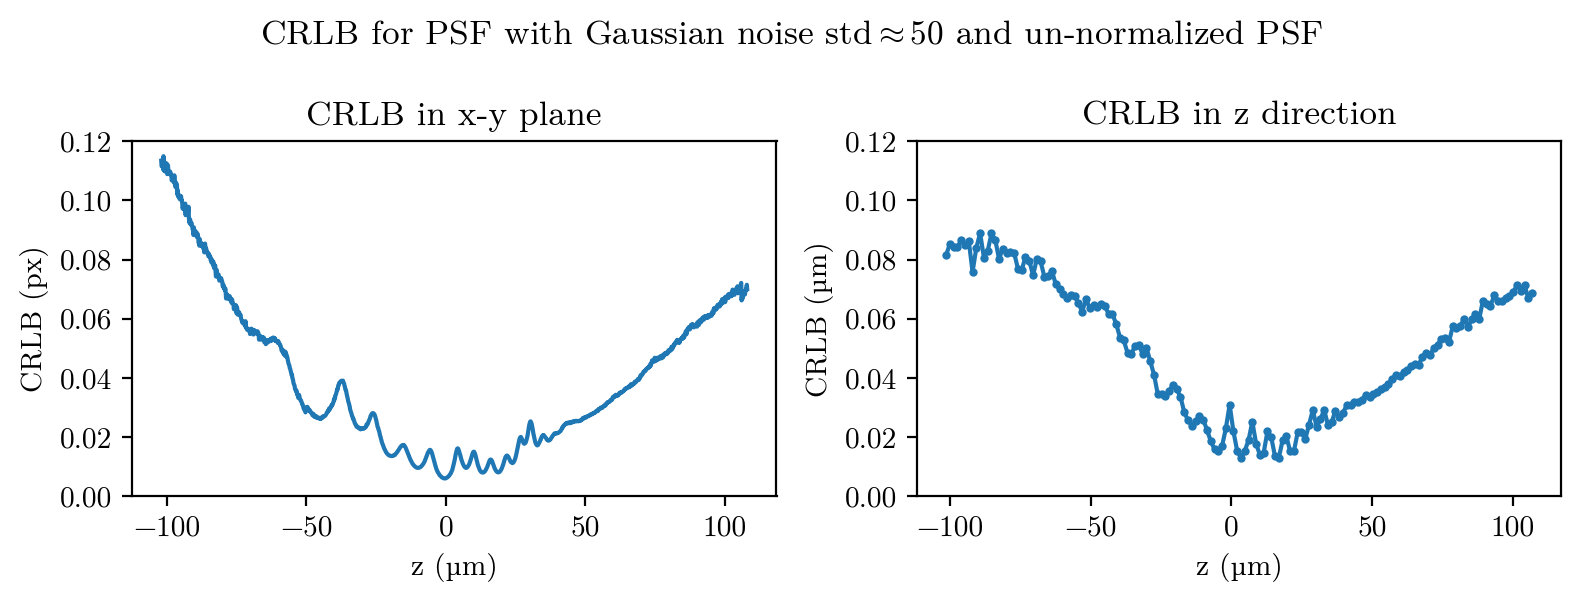

In [5]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, shift
from scipy.optimize import curve_fit

import sys
if ".." not in sys.path: sys.path.append("..")
import image_generator as ig
from tqdm import tqdm

# Parameters
AMP = 1              # Amplitude of the PSF
sigma_noise = 50       # Std dev of Gaussian noise
psf = (np.load("../ripples_downsampled.npy")).astype(np.int32).clip(0,2**16-1)  # Load PSF data

# Numerical derivatives w.r.t. x and y
def derivative(psf, axis, delta=1): # delta : small shift in x or y
    shift_vec = [0, 0]
    shift_vec[axis] = delta
    psf_forward = ((1-delta)*psf+delta*np.roll(psf, shift=1, axis=axis))
    shift_vec[axis] = -delta
    psf_backward = ((1-delta)*psf+delta*np.roll(psf, shift=-1, axis=axis))
    return (psf_forward - psf_backward) / (2 * delta)

def derivative_z(psf, z, alpha=1): # alpha : small shift in z
    if z <1 and z > psf.shape[0]-2:
        raise ValueError("z must be between 1 and psf.shape[0]-2")
    psf_forward =  ((psf[z].T*(1-alpha) + psf[z-1].T*alpha).T)
    psf_backward = ((psf[z].T*(1-alpha) + psf[z+1].T*alpha).T)
    return (psf_forward - psf_backward) / (2 * alpha)

def compute_crlb(z):
    dh_dx = derivative(psf[z], axis=1)  # x-axis derivative
    dh_dy = derivative(psf[z], axis=0)  # y-axis derivative
    dh_dz = derivative_z(psf,z)  # z-axis derivative

    # Compute Fisher Information Matrix (FIM)
    I_xx =  np.sum(dh_dx**2)
    I_yy =  np.sum(dh_dy**2)
    I_zz =  np.sum(dh_dz**2)


    I_xy =  np.sum(dh_dx * dh_dy)
    I_xz =  np.sum(dh_dx * dh_dz)
    I_yz =  np.sum(dh_dy * dh_dz)

    FIM = np.array([[I_xx, I_xy, I_xz],
                    [I_xy, I_yy, I_yz],
                    [I_xz, I_yz, I_zz]])

    CRLB = np.diag(np.linalg.inv(FIM))
    return sigma_noise/AMP *np.sqrt(CRLB)

# # Output results
# print("Fisher Information Matrix:\
# n", FIM)
# print("CRLB Covariance Matrix:\n", CRLB)



z_index = np.arange(1, 1566)
z_space = np.linspace(-102, 108, 1565)


std_x, std_y, std_z = np.array([compute_crlb(z_i) for z_i in z_index]).T
std_xy = np.sqrt((std_x**2+std_y**2)/2)
std_z *= 0.134

# Optional: visualize
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(z_space, std_xy)
plt.xlabel("z (µm)")
plt.ylabel("CRLB (px)")
plt.title("CRLB in x-y plane")
plt.ylim(0,0.12)

plt.subplot(1,2,2)
k=10
plt.plot(z_space[k//2:-k//2:k], np.convolve(std_z, np.ones(k)/k, mode='same')[k//2:-k//2:k], ".-",ms=4)
plt.xlabel("z (µm)")
plt.ylabel("CRLB (µm)")
plt.title("CRLB in z direction")
plt.suptitle("CRLB for PSF with Gaussian noise std$\\approx 50$ and un-normalized PSF")
plt.tight_layout()
plt.ylim(0,0.12)
plt.show()

# Save the results
np.savez("crlb_results.npz", z_space=z_space, std_z=std_z, std_xy=std_xy)

In [14]:
alphas = np.linspace(0,0.1,101)
sums_int = []
sums_float = []
from tqdm import tqdm
for alpha in tqdm(alphas):
    val = alpha*np.abs(psf-2e4).clip(0,2**16-1)
    sums_float.append(np.sum((val), axis=(1,2)))
    sums_int.append(np.sum((val).astype(np.uint16), axis=(1,2)))
sums_int = np.array(sums_int)
sums_float = np.array(sums_float)


100%|██████████| 101/101 [00:48<00:00,  2.10it/s]


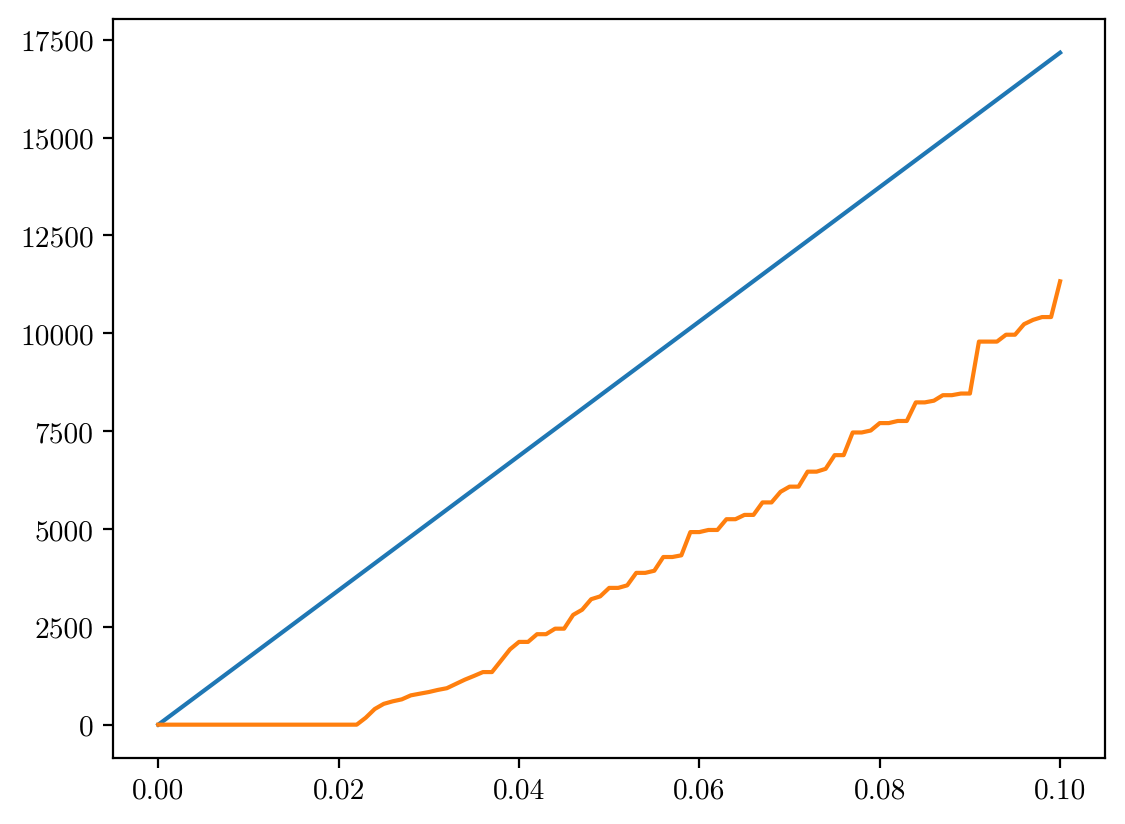

In [19]:
plt.plot(alphas, sums_float[:,-1])
plt.plot(alphas, sums_int[:,-1])

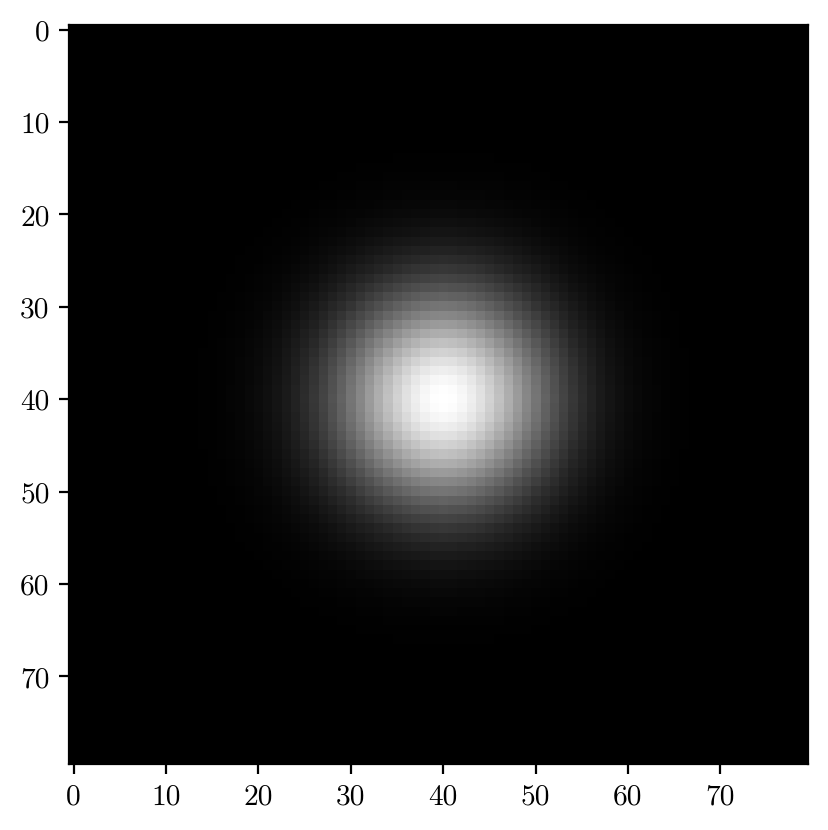

In [3]:
import image_generator as ig
objects = ig.pd.DataFrame({"label":"Spot", "i":2**15, "s":8, "x":40,"y":40}, index=[0])
img, _ = ig.generateImage(objects, (80,80),noise=0, refstack=np.zeros((40,40,40)))
plt.imshow(img, cmap='gray')
img /= img.max()
img = img.astype(np.uint16)
dh_dx = derivative(img, axis=1)  # x-axis derivative
dh_dy = derivative(img, axis=0)  # y-axis derivative

# Compute Fisher Information Matrix (FIM)
I_xx =  np.sum(dh_dx**2)
I_yy =  np.sum(dh_dy**2)


I_xy =  np.sum(dh_dx * dh_dy)

FIM = np.array([[I_xx, I_xy],
                [I_xy, I_yy]])
CRLB = np.sqrt(np.diag(np.linalg.inv(FIM)))

In [4]:
CRLB

array([3.05180438e-05, 3.05180438e-05])